In [1]:
%%html
<link href="https://v1.fontapi.ir/css/Vazir" rel="stylesheet">
<link rel="stylesheet" href="style.css">

# <div class="farsi">تمرین چهارم: Sentiment Analysis</div>
## <div class="farsi right">محمد علی صدرایی- 400210993</div>
## <div class="farsi right">محمد مظفری- 400201167</div>
## <div class="farsi right">علیرضا زارع نژاد- 400201101</div>

In [2]:
# This cell contains all the necessary imports for this notebook.
import re
import time
import shap
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from hazm import Normalizer, Stemmer, Lemmatizer, word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split

pd.set_option('display.max_colwidth', None)

In [3]:
import arabic_reshaper
from bidi.algorithm import get_display

def fix_persian_list(list_of_str):
    return [get_display(arabic_reshaper.reshape(item)) for item in list_of_str]

In [4]:
# Here we read the data from given files.
# Files are stored in a folder named "data" next to this notebook.

train_df = pd.read_csv("data/train.csv", encoding="utf-8")
eval_df = pd.read_csv("data/eval.csv", encoding="utf-8")

<div class="farsi">همانطور که در خروجی سلول بعد میبینیم فایل train دارای 800 داده و فایل eval دارای 200 داده برای ارزیابی دارد.</div>


In [5]:
# A quick look inside the train and eval data.
# We don't touch the test file yet.

train_df.info()
print()
eval_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  800 non-null    int64  
 1   comment     800 non-null    object 
 2   rate        800 non-null    float64
dtypes: float64(1), int64(1), object(1)
memory usage: 18.9+ KB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  200 non-null    int64  
 1   comment     200 non-null    object 
 2   rate        200 non-null    float64
dtypes: float64(1), int64(1), object(1)
memory usage: 4.8+ KB


In [6]:
train_df.head(10)

,Unnamed: 0,comment,rate
0,2587,پردازنده های Core i5 و Core i3 نیز ذاتا دو هسته ای با توان ساختن دو هسته‌ی مجازی دیگر هستند.,0.00
1,22591,سلام به دوستای عزیزم \nعزاداری هاتون قبول باشه,1.00
2,141037,کلا پولتون رو دور نریزیزد,-1.00
3,58593,از صمیم قلب امیدوارم دایانا با کارن بمونه و پوریا رو فراموش کنه,1.00
4,5712,آنطور که اپل ادعا می کند آیپاد شافل دارای طراحی فوق العاده است، که البته ادعایی غیر واقعی نیست.,1.00
5,168940,در کل کفش بدی نیست ولی من خودم دادشتم دور دوخت ولی با این قیمت این کفش ارزش خرید نداره,0.68
6,6751,به دلیل وجود پنل IPS بر روی این صفحه نمایش، عملکرد آن در زوایای مختلف نیز بسیار مناسب و قابل قبول است.,1.00
7,43698,همکارم این دانگل رو خریده بود و بعد از گذشت حدود 10 روز استفاده میگفت که بسیار دانگل خوبی است. لگ ندارد. افت کیفیت ندارد. برد خوبی دارد در حد 5 متر، خیلی راحت متصل میشود و داغ نمیکند.\nدر شگفت انگیز ارزش خرید بالایی دارد. \nدیجی جان شگفت انگیزش کن من و چندتا دوستان میخوایم خرید کنیم.,0.20
8,34297,چقد فاصله داریم!!!,1.00
9,161474,خیلی زود شارژ خالی میکنه,0.82


In [7]:
# check missing values (which there isn't any)
train_df.isna().mean()

Unnamed: 0    0.0
comment       0.0
rate          0.0
dtype: float64

<div class="farsi">در این قسمت نگاهی به توزیع داده ها با برچسب های مختلف می اندازیم. در نمودار bar زیر میبینیم که برای هر بازه از مقادیر target چه تعداد داده آموزشی داریم.</div>

Text(0.5, 0, 'Number of rates')

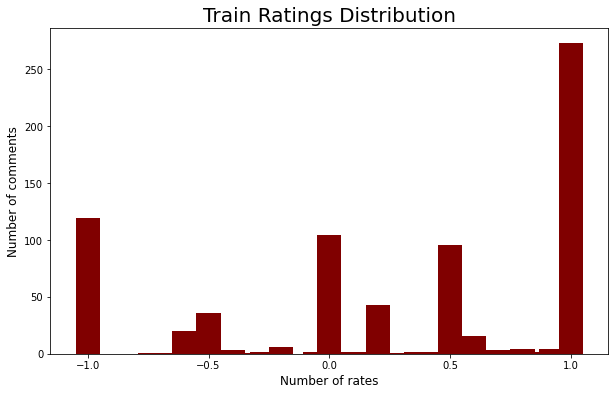

In [8]:
rates_count = train_df['rate'].value_counts()
rates_count = rates_count.sort_index()

fig = plt.figure(figsize=(10, 6))
plt.bar(rates_count.index, rates_count.values, color ='maroon', width=0.1)
plt.title("Train Ratings Distribution", fontsize = 20)
plt.ylabel('Number of comments', fontsize = 12)
plt.xlabel('Number of rates', fontsize = 12)

<div class="farsi justify">چون هدف آموزش یک classifier است باید برچسب را به صورت categorical بدست آوریم. به همین دلیل به مقادیر بزرگتر از 0 برچسب 1 و به مقادیر 0 یا کوچکتر از از آن برچسب منفی 1 اختصاص میدهیم.</div>

In [9]:
# convert rate to 1 and -1 for binary classification
train_df.loc[train_df['rate'] >= 0, 'rate'] = 1
train_df.loc[train_df['rate'] < 0, 'rate'] = 0

eval_df.loc[eval_df['rate'] >= 0, 'rate'] = 1
eval_df.loc[eval_df['rate'] < 0, 'rate'] = 0

Text(0.5, 0, 'Number of rates')

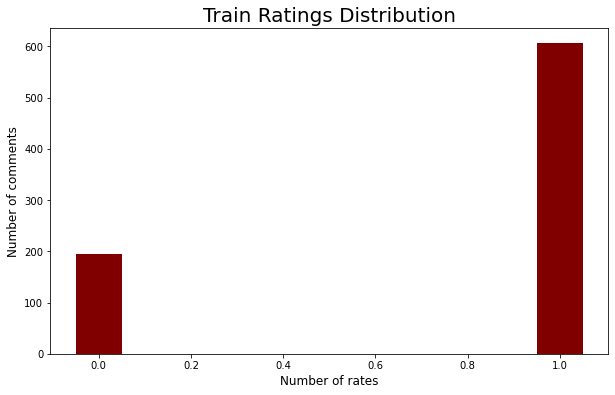

In [10]:
rates_count = train_df['rate'].value_counts()
rates_count = rates_count.sort_index()

fig = plt.figure(figsize=(10, 6))
plt.bar(rates_count.index, rates_count.values, color ='maroon', width=0.1)
plt.title("Train Ratings Distribution", fontsize = 20)
plt.ylabel('Number of comments', fontsize = 12)
plt.xlabel('Number of rates', fontsize = 12)

In [11]:
# Tried balancing the dataset by copying negative class data
# But didn't observe any improvement.

# negative_copy1 = train_df[train_df.rate == 0].copy()
# negative_copy2 = train_df[train_df.rate == 0].copy()
# negative_copy3 = train_df[train_df.rate == 0].copy()

# data = pd.concat([train_df, negative_copy1, negative_copy2, negative_copy3])
# train_df = data

In [12]:
# Let's create train and validation data
y_train = train_df['rate'].values
X_train = train_df['comment'].values
y_val = eval_df['rate'].values
X_val = eval_df['comment'].values

In [13]:
def remove_non_persian_characters(s):
    """
    This functino takes a string as input and deletes all characters except persian characters from it.
    This preprocessing step will help the accuracy of our classifier.
    """

    main_per_chars = 'ابپتثجچحخدذرزژسشصضطظعغفقکگلمنوهی'
    other_per_chars = 'آئءيؤإأ'
    white_space = '\u200c '
    per_digits = '۰۱۲۳۴۵۶۷۸۹'
    s = re.sub(r'[^{}{}{}{}]'.format(main_per_chars,
               other_per_chars, white_space, per_digits), '', s)
    return s

<div class="farsi justify">قبل از آموزش مدل بهتر است یک مرحله پیش پردازش بر روی داده ها انجام شود. پیش پردازش انجام شده در این قسمت به این صورت است که تمام کلمات غیر فارسی حذف میشوند، از normalizer موجود در هضم استفاده میشود تا متن نرمال شود و همچنین کلمات را با استفاده از ابزار هضم به شکل stem شده برده میشوند.</div>

In [14]:
normalizer = Normalizer()           # get hazm normalizer
stemmer = Stemmer()                 # get hazm stemmer
lemmatizer = Lemmatizer()           # get hazm lemmatizer (we don't use this because it makes accuracy worse)

# Here we normalize our training data.
for i in range(len(X_train)):
    comment = X_train[i]
    comment = remove_non_persian_characters(comment)
    comment = ' '.join(comment.split())
    comment = normalizer.normalize(comment)
    comment = word_tokenize(comment)
    comment = [stemmer.stem(token) for token in comment]
    # comment = [lemmatizer.lemmatize(token) for token in comment]
    comment = ' '.join(comment)
    X_train[i] = comment

# Here we normalize our validation data.
for i in range(len(X_val)):
    comment = X_val[i]
    comment = remove_non_persian_characters(comment)
    comment = ' '.join(comment.split())
    comment = normalizer.normalize(comment)
    comment = word_tokenize(comment)
    comment = [stemmer.stem(token) for token in comment]
    # comment = [lemmatizer.lemmatize(token) for token in comment]
    comment = ' '.join(comment)
    X_val[i] = comment


In [15]:
start_time = time.time()
cv = CountVectorizer(binary=True, min_df = 10, max_df = 0.95)
cv.fit_transform(X_train);

<div class="farsi justify">حال زمان آموزش مدل فرا رسیده است. ابتدا feature ها استخراج میشوند. برای استخراج فیچر ها از Tfidf کلمات استفاده میکنیم. برای بدست آوردن tfidf هم از کتابخانه sklearn استفاده میشود.</div>
<div class="farsi justify">پس از اینکه فیچرهای هر داده بدست آورده شد میتوانیم یک مدل ساده logistic regression را بر روی داده ها آموزش دهیم. نیازی به پیاده سازی این مدل نیست زیرا در کتابخانه sklearn موجود است.</div>

In [16]:
start_time = time.time()
tfidf_v = TfidfVectorizer(use_idf=True, min_df = 10, max_df = 0.95)
# tfidf_v = TfidfVectorizer(use_idf=True, min_df = 10, max_df = 0.2)
# tfidf_v = TfidfVectorizer()
tfidf_v.fit_transform(X_train)
train_feature_set = tfidf_v.transform(X_train)              # extract features for train data
val_feature_set = tfidf_v.transform(X_val)                  # extract features for validation data
print("Time takes to convert text input into feature vector: ", round((time.time() - start_time) / 60, 2), " mins")


Time takes to convert text input into feature vector:  0.0  mins


In [17]:
start_time = time.time()
lr = LogisticRegression(solver = 'liblinear', random_state = 42, max_iter=1000)
lr.fit(train_feature_set, y_train)              # train model on training data
y_pred = lr.predict(val_feature_set)            # predict validation data labels
print("Time takes to train model and make predictions: ", round((time.time() - start_time) / 60, 2), " mins")


Time takes to train model and make predictions:  0.0  mins


<div class="farsi">پس از آموزش مدل، نتیجه عملکرد مدل بر روی داده های validation به صورت زیر است. همچنین در سلول بعدی confusion matrix نیز رسم شده است.</div>

In [18]:
y_pred_train = lr.predict(train_feature_set)

# Report accuracy and f1 score on train and validation sets.
print("Train Accuracy: ", metrics.accuracy_score(y_train, y_pred_train))
print("Train F1: ", metrics.f1_score(y_train, y_pred_train))
print()
print("Validation Accuracy: ", metrics.accuracy_score(y_val, y_pred))
print("Validation F1: ", metrics.f1_score(y_val, y_pred))

Train Accuracy:  0.79625
Train F1:  0.8805860805860806

Validation Accuracy:  0.735
Validation F1:  0.8436578171091446


Text(0.5, 1.0, 'Logistic Regression Confusion matrix, with normalization')

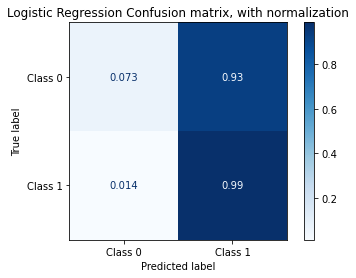

In [19]:
disp = metrics.plot_confusion_matrix(lr, val_feature_set, y_val,
                                 display_labels=['Class 0', 'Class 1'],
                                 cmap=plt.cm.Blues,
                                 normalize='true')
disp.ax_.set_title('Logistic Regression Confusion matrix, with normalization')

<div class="farsi">در نهایت مدل به دست آمده را بر روی داده تست ارزیابی میکنیم</div>

In [20]:
# Read test data
train_df = pd.read_csv("data/train.csv", encoding="utf-8")
eval_df = pd.read_csv("data/eval.csv", encoding="utf-8")
test_df = pd.read_csv("data/test.csv", encoding="utf-8")

def calc_accuracy_lr(lr, df):
    df.loc[df['rate'] >= 0, 'rate'] = 1
    df.loc[df['rate'] < 0, 'rate'] = 0

    _y = df['rate'].values
    _x = df['comment'].values


    # Here we normalize our test data.
    for i in range(len(_x)):
        comment = _x[i]
        comment = remove_non_persian_characters(comment)
        comment = ' '.join(comment.split())
        comment = normalizer.normalize(comment)
        comment = word_tokenize(comment)
        comment = [stemmer.stem(token) for token in comment]
        # comment = [lemmatizer.lemmatize(token) for token in comment]
        comment = ' '.join(comment)
        _x[i] = comment

    # Extract Tfidf features.
    feature_set = tfidf_v.transform(_x)

    # Predict labels using logistic regression model.
    y_pred_test = lr.predict(feature_set)
    
    acc = metrics.accuracy_score(_y, y_pred_test)
    f1 = metrics.f1_score(_y, y_pred_test)
    return acc, f1

# Report accuracy and f1 score.
for df, dataset_label in [(train_df, 'Train'), (test_df, 'Test'), (eval_df, 'Eval')]:
    acc, f1 = calc_accuracy_lr(lr, df)
    print(f"{dataset_label} Accuracy: {acc}")
    print(f"{dataset_label} F1: {f1}")
    print()


Train Accuracy: 0.79625
Train F1: 0.8805860805860806

Test Accuracy: 0.7058823529411765
Test F1: 0.8214285714285714

Eval Accuracy: 0.735
Eval F1: 0.8436578171091446



<div class="farsi justify">در سلول های بعدی کلمات کلیدی برای دسته بندی آورده شده است. آنچه در نمودار ها نشان داده شده، کلماتی هستند که در داده های آن کلاس سهم بیشتری داشته اند.</div>

['نیز', 'دوربین', 'نظر', 'کاملا', 'قشنگ', 'می', 'هس', 'وجود', 'بسیار', 'خود']


Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


Text(0.5, 0, 'Word')

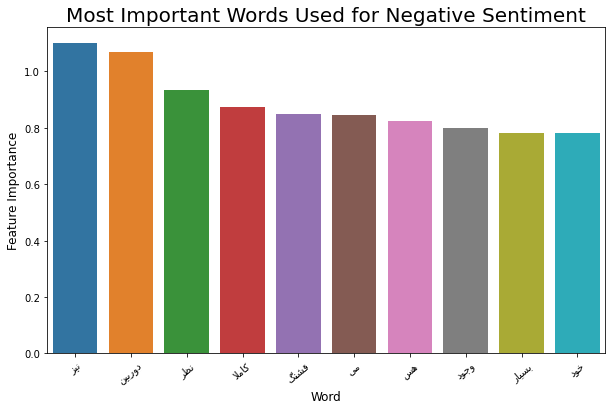

In [21]:
TOP = 10

feature_importance = lr.coef_[0]
sorted_idx = np.argsort(feature_importance)

top_pos_w = [list(cv.vocabulary_.keys())[list(cv.vocabulary_.values()).index(w)] for w in sorted_idx[range(-1,-TOP-1, -1)]]

print(top_pos_w)

fig = plt.figure(figsize=(10, 6))
ax = sns.barplot(fix_persian_list(top_pos_w), feature_importance[sorted_idx[range(-1,-TOP-1, -1)]])
plt.title("Most Important Words Used for Negative Sentiment", fontsize=20)
x_locs, x_labels = plt.xticks()
plt.setp(x_labels, rotation=40)
plt.ylabel('Feature Importance', fontsize=12)
plt.xlabel('Word', fontsize=12)

['خو', 'اصلا', 'خوشمزه', 'ارسال', 'موقع', 'کیف', 'بود', 'قیمت', 'زیر', 'تازه']


Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


Text(0.5, 0, 'Word')

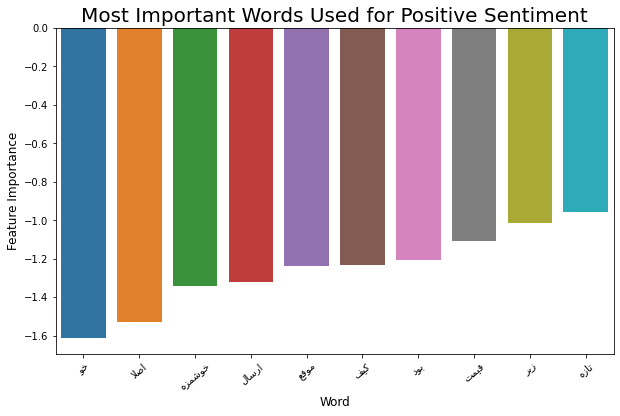

In [22]:
TOP = 10

sorted_idx = np.argsort(feature_importance)

top_neg_w = [list(cv.vocabulary_.keys())[list(cv.vocabulary_.values()).index(w)] for w in sorted_idx[:TOP]]

print(top_neg_w)

fig = plt.figure(figsize=(10, 6))
ax = sns.barplot(fix_persian_list(top_neg_w), feature_importance[sorted_idx[:TOP]])
plt.title("Most Important Words Used for Positive Sentiment", fontsize=20)
x_locs,x_labels = plt.xticks()
plt.setp(x_labels, rotation=40)
plt.ylabel('Feature Importance', fontsize=12)
plt.xlabel('Word', fontsize=12)

In [23]:
explainer = shap.LinearExplainer(lr, train_feature_set, feature_dependence="independent")
test_feature_set = tfidf_v.transform(test_df['comment'].values)
shap_values = explainer.shap_values(test_feature_set)
X_test_array = test_feature_set.toarray() # we need to pass a dense version for the plotting functions

The option feature_dependence has been renamed to feature_perturbation!
The option feature_perturbation="independent" is has been renamed to feature_perturbation="interventional"!
The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


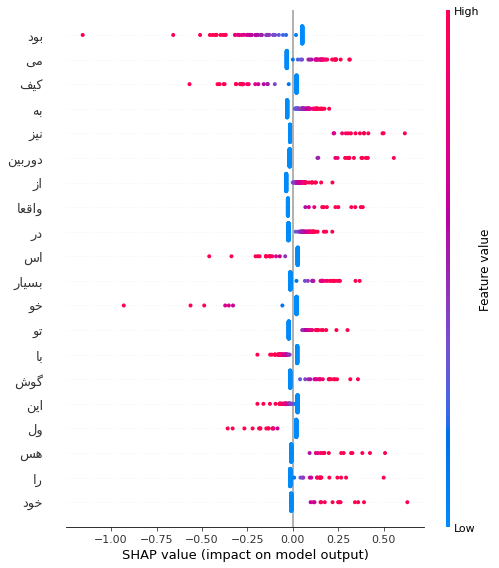

In [24]:
shap.summary_plot(shap_values, X_test_array, feature_names=fix_persian_list(tfidf_v.get_feature_names()))